In [92]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [93]:
def load_data(data_path):
    df = pd.read_csv(data_path, sep='\t', parse_dates=['ActivityTimeStamp'])
    df = df.sort_values(by=['Incident ID'])
    return df


In [94]:
data = load_data('./data/incidentProcess_custom.csv')

In [198]:
data.isnull().values.sum()

279328

In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303819 entries, 0 to 303818
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Incident ID              303819 non-null  object        
 1   Activity                 303819 non-null  object        
 2   ActivityTimeStamp        303819 non-null  datetime64[ns]
 3   Asset Affected           303819 non-null  object        
 4   Asset Type Affected      303819 non-null  object        
 5   Asset SubType Affected   303819 non-null  object        
 6   Service Affected         303819 non-null  object        
 7   Status                   303819 non-null  object        
 8   Impact                   303819 non-null  int64         
 9   Urgency                  303819 non-null  int64         
 10  Priority                 303819 non-null  int64         
 11  Category                 303819 non-null  object        
 12  Number of Reassi

In [96]:
def incident_sorted_list(data, incident_id):
    '''
    '''
    df = pd.DataFrame()
    df = data[data['Incident ID'] == incident_id] # select all rows with incident_id
    # df['ActivityTimeStamp'] = pd.to_datetime(df['ActivityTimeStamp']) # parse as timestamp
    # df['ActivityTimeStamp'] = df['ActivityTimeStamp'].apply(
    #     lambda x: dt.datetime.strftime(x, '%Y-%d-%m %H:%M:%S')) # transform
    df = df.sort_values(by=['ActivityTimeStamp'], ascending=True)
    # print(df)
    return df

In [107]:
def check_ping_pong(df):
    pingpong = 0
    assignments = []
    timedeltas = []
    for i in range(df.shape[0] - 1):
        activityA = df['Activity'].iloc[i]
        activityB = df['Activity'].iloc[i+1]
        if activityA == activityB:
            if df['Assignment Group'].iloc[i] != df['Assignment Group'].iloc[i+1]:
                assignments.append((df['Assignment Group'].iloc[i], df['Assignment Group'].iloc[i+1], activityA))
                timedeltas.append(df['ActivityTimeStamp'].iloc[i+1] - df['ActivityTimeStamp'].iloc[i])
                # hier dus eigenlijk een lijst met tuple (teamA en TeamB plus timestamps en misschien ook de activiteit in kwestie) returnen en na alle incidenten opslaan
                # print(df['Assignment Group'].iloc[i])
                # print(df['Assignment Group'].iloc[i+1])
                pingpong += 1
    return pingpong, assignments, timedeltas

In [108]:
def get_unique_incidents(df):
    return list(df['Incident ID'].unique())

In [109]:
get_unique_incidents(data)[100]

'IM0000147'

In [110]:
pd.options.mode.chained_assignment = None

In [111]:
pingpong_df = pd.DataFrame()
asset_types = []
pings_list = []
timedeltas = []
for (pos, i_id) in enumerate(get_unique_incidents(data)):
    if pos == 1000:
        break
    sorted_incident = incident_sorted_list(data, i_id)
    pings, activities, timedelta = check_ping_pong(sorted_incident)
    timedeltas.append(timedelta)
    # print(sorted_incident['Asset Type Affected'].iloc[0], pings, activities)
    asset_types.append(sorted_incident['Asset Type Affected'].iloc[0])
    pings_list.append(pings)
    pingpong_df = pingpong_df.append({"Incident ID": i_id, "pings": pings}, ignore_index=True)

asset_type_pings_df = pd.DataFrame()
asset_type_pings_df['pings'] = pings_list
asset_type_pings_df['Asset Type'] = asset_types


subapplication 0 []
application 1 [('TEAM0003', 'TEAM9999', 'Assign to 1st Line Operator')]
application 0 []
application 1 [('TEAM0001', 'TEAM0003', 'Assign to 2nd Line Operator')]
application 0 []
application 0 []
application 0 []
application 0 []
application 0 []
application 0 []
application 1 [('TEAM0002', 'TEAM0003', 'Assign to 1st Line Operator')]
application 0 []
application 1 [('TEAM0002', 'TEAM0171', 'Assign to 2nd Line Operator')]
application 4 [('TEAM0005', 'TEAM0003', 'Assign to 1st Line Operator'), ('TEAM0002', 'TEAM0003', 'Assign to 1st Line Operator'), ('TEAM0005', 'TEAM0003', 'Assign to 1st Line Operator'), ('TEAM0003', 'TEAM0002', 'Assign to 2nd Line Operator')]
application 0 []
application 1 [('TEAM0001', 'TEAM0003', 'Assign to 2nd Line Operator')]
subapplication 0 []
subapplication 0 []
application 0 []
application 0 []
application 1 [('TEAM0002', 'TEAM0003', 'Assign to 1st Line Operator')]
application 0 []
application 0 []
application 2 [('TEAM0010', 'TEAM9999', 'Ass

In [114]:
timedeltas
flat_deltas = [x for xs in timedeltas for x in xs]


In [116]:
deltas_df = pd.DataFrame()
deltas_df['Time Deltas'] = flat_deltas

In [117]:
deltas_df.mean()

Time Deltas   4 days 05:45:03.800248911
dtype: timedelta64[ns]

In [118]:
deltas_df.std()

Time Deltas   18 days 16:25:44.792150502
dtype: timedelta64[ns]

In [134]:
deltas_df.max()

Time Deltas        220 days 06:55:14
Time Deltas [s]           19032914.0
dtype: object

In [192]:
deltas_df['Time Deltas [s]'] = deltas_df['Time Deltas'].astype('timedelta64[s]')
result  = deltas_df[deltas_df['Time Deltas'].astype('timedelta64[s]').between(60 * 60 * 48, 60 * 60 * 96)] 


In [193]:
result.shape

(104, 2)

Text(0.5, 0, 'Days delay')

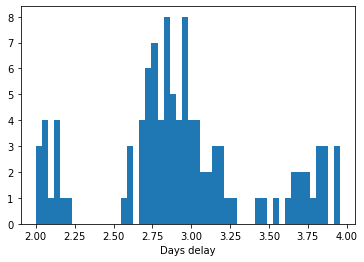

In [195]:
# deltas_df['Time Deltas'].dt.days.plot.hist(bins=20)
plt.hist((result['Time Deltas'].astype('timedelta64[h]') / 24), bins=50)
plt.xlabel("Days delay")

Text(0, 0.5, 'Incident count')

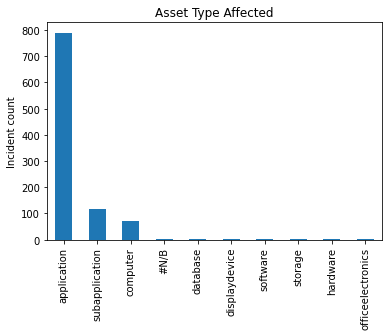

In [87]:
# asset_type_pings_df['Asset Type'].value_counts().plot()
asset_type_pings_df['Asset Type'].value_counts().plot(kind='bar')
plt.title("Asset Type Affected")
plt.ylabel("Incident count")

In [88]:
asset_type_pings_df['Asset Type'].value_counts()

application          790
subapplication       118
computer              73
#N/B                   4
database               4
displaydevice          3
software               3
storage                2
hardware               2
officeelectronics      1
Name: Asset Type, dtype: int64

In [90]:
asset_type_pings_df.shape

(1000, 2)

In [91]:
for val in asset_type_pings_df['Asset Type'].value_counts():
    print(val / 1000)

0.79
0.118
0.073
0.004
0.004
0.003
0.003
0.002
0.002
0.001


In [83]:
print(pingpong_df['pings'].min())

0


(array([58., 18.,  6., 11.,  2.,  1.,  2.,  1.,  0.,  1.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

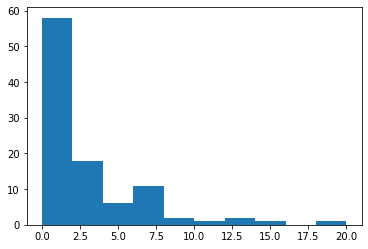

In [81]:
plt.hist(pingpong_df['pings'])